In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [41]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.utils import shuffle

import xgboost as xgb

from nf.flows import *
from nf.models import NormalizingFlowModel
import matplotlib.pyplot as plt

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [4]:
data_dir = '../data/data_calibsample'
particle = 'muon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
37867,1.233500,12841.50,2.47055,234,-29.32320,-11.777800,2.528180,-34.43500,-29.32320
261559,0.885405,8128.56,4.04301,189,-20.70120,-11.017100,-2.309460,-20.70120,-20.70120
244324,-0.342785,9892.81,4.03592,284,-34.33680,-8.643920,-1.851900,-34.33770,-34.33680
433230,1.191330,51392.90,3.99923,175,-2.10827,0.479287,0.066592,-10.97910,0.41417
16854,0.942359,57842.80,4.38533,279,-6.60866,0.009240,0.191240,-6.15369,-7.78784


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(1984209, 9)

In [7]:
X, Y, weights = data[features].values, data[dlls].values, data[weight_filed].values
train_size = data.shape[0] * 7 // 10

X_train, Y_train, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val, Y_val, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train.shape, X_val.shape

((1388946, 3), (595263, 3))

In [8]:
# scaler = StandardScaler()
scaler = scaler = QuantileTransformer(
    output_distribution="normal",
    n_quantiles=100000,
    subsample=int(1e10)
)
scaler.fit(Y_train)
Y_train_scaled = scaler.transform(Y_train)

In [9]:
# torch.cuda.set_device(2)
device = 'cuda'

In [10]:
dataset = TensorDataset(torch.from_numpy(Y_train_scaled.astype(np.float32)).to(device))
dataloader = DataLoader(dataset, batch_size=8192)
dim = Y.shape[1]

In [11]:
def bin_probs(arr, vals, bins):
    arr_bins = np.cumsum(arr.reshape(-1, 1) > bins, axis=1)[:, -1] - 1
    bin_range = np.arange(bins.shape[0] - 1)
    bin_vals = (arr_bins == bin_range.reshape(-1, 1)) * vals
    bin_vals = np.sum(bin_vals, axis=1) / (np.sum(bin_vals != 0.0, axis=1) + 0.0001)
    new_bins = (bins[:-1] + bins[1:]) / 2
    
    return new_bins, bin_vals

In [12]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x.to('cpu')).to(x.device)
        return z, prior_logprob, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,self.dim))
        if z.dim() != 2: z = self.prior.sample((n_samples,))
        x, _ = self.backward(z)
        return x

In [13]:
class MAF(nn.Module):
    """
    Masked auto-regressive flow.

    [Papamakarios et al. 2018]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i, 2, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        init.uniform_(self.initial_param, -math.sqrt(0.5), math.sqrt(0.5))

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

In [14]:
flows = [MAF(dim=dim, hidden_dim=32).to(device), MAF(dim=dim, hidden_dim=32).to(device), 
         MAF(dim=dim, hidden_dim=32).to(device), MAF(dim=dim, hidden_dim=32).to(device)]
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
model = NormalizingFlowModel(dim, prior, flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)

In [15]:
metrics = []

984


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


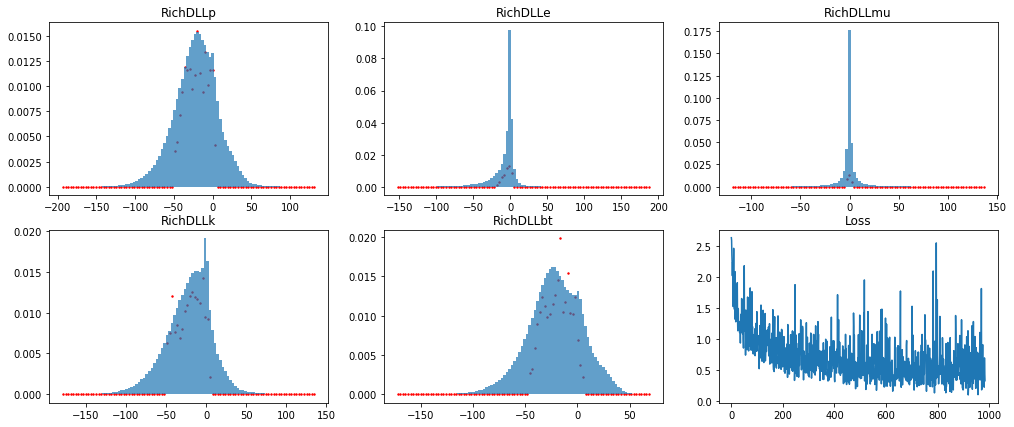

KeyboardInterrupt: 

In [16]:
epoches = 1000
# epoches = 1

for epoch in range(len(metrics), epoches):
    model.train()
    for step, batch_x in enumerate(dataloader):
        batch_x = batch_x[0].to(device)
        optimizer.zero_grad()
        z, logp_z, log_det = model(batch_x)
        logp_x = logp_z + log_det
        loss = -torch.mean(logp_x)
        loss.backward()
        optimizer.step()
    metrics.append(loss.mean().detach())

    if epoch % 1 == 0:
        clear_output(False)
        print(epoch)
        model.eval()
        with torch.no_grad():
            X_test = np.random.uniform(-1, 1, (100000, dim)).astype('float32')
            z, logp_z, log_det = model(torch.from_numpy(X_test).to(device))
            logp_x = logp_z + log_det
            Y_pred = np.exp(logp_x.cpu().numpy())
            X_test = scaler.inverse_transform(X_test)

            fig, axs = plt.subplots(2, 3, figsize=(17, 7))
            for i in range(dim):
                _, bins, _ = axs[i // 3, i % 3].hist(Y_val[:, i], 100, label="data", normed=True, alpha=0.7)
                axs[i // 3, i % 3].scatter(*bin_probs(X_test[:, i], Y_pred, bins), label="generated", c='red', s=2)
                axs[i // 3, i % 3].set_title(dlls[i])
            axs[1, 2].plot(np.arange(len(metrics)), metrics)
            axs[1, 2].set_title('Loss')
        plt.show()

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]


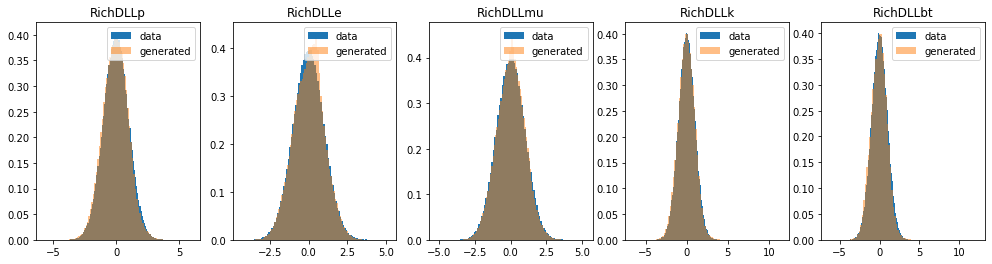

In [29]:
model.eval()
with torch.no_grad():
    Z_test = np.random.normal(0, 1, (len(Y_val), dim)).astype('float32')
    x, log_det = model.backward(torch.from_numpy(Z_test).to(device))
    x = x.cpu().numpy()
#     x = scaler.inverse_transform(x)
    
    fig, axs = plt.subplots(1, dim, figsize=(17, 4))
    Y_val_t = scaler.transform(Y_val)
    for i in range(dim):
#         axs[i].hist(Y_val[:, i], 100, label="data", normed=True)
        axs[i].hist(Y_val_t[:, i], 100, label="data", normed=True)
        axs[i].hist(x[:, i], 100, label="generated", normed=True, alpha=0.5)
        axs[i].legend()
        axs[i].set_title(dlls[i])

In [30]:
# d1 = pd.DataFrame(Y_val, columns=dlls)
d1 = pd.DataFrame(Y_val_t, columns=dlls)
d2 = pd.DataFrame(x, columns=dlls)
d1.head()

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
0,-1.632348,-0.616801,-0.900522,-2.080689,-1.526170
1,-1.174244,-0.633390,1.456520,-1.338117,-1.277782
2,0.025061,-1.213380,0.976685,-0.063480,0.032085
3,2.256256,0.037371,-0.382714,0.524571,1.282551
4,-0.399223,0.395375,0.407347,-0.166487,-0.703852


In [31]:
def f(data, dlls):
    fig, axs = plt.subplots(len(dlls), len(dlls), figsize=(17, 15))#, sharex=True, sharey=True)

    for j, dll1 in enumerate(dlls):
        for i, dll2 in enumerate(dlls):
            q1_1, q1_99 = data[dll1].quantile(0.03), data[dll1].quantile(0.97)
            q2_1, q2_99 = data[dll2].quantile(0.03), data[dll2].quantile(0.97)

            if i == j:
                arr = data[[dll1]].query(f'{q1_1} < {dll1} < {q1_99}')
                axs[i, i].hist(arr[dll1], 100)
                axs[i, i].set_title(dll1)
            else:
                arr = data[[dll1, dll2]] \
                    .query(f'{q1_1} < {dll1} < {q1_99}') \
                    .query(f'{q2_1} < {dll2} < {q2_99}')

                axs[i, j].hist2d(arr[dll1], arr[dll2], (100, 100, ))
                m1, m2 = max(q1_1, q2_1), min(q1_99, q2_99)
                axs[i, j].plot(np.arange(m1, m2, 1), np.arange(m1, m2, 1), c='red')
                axs[i, j].set_title(dll1 + ' ' + dll2)

## Original data distributions

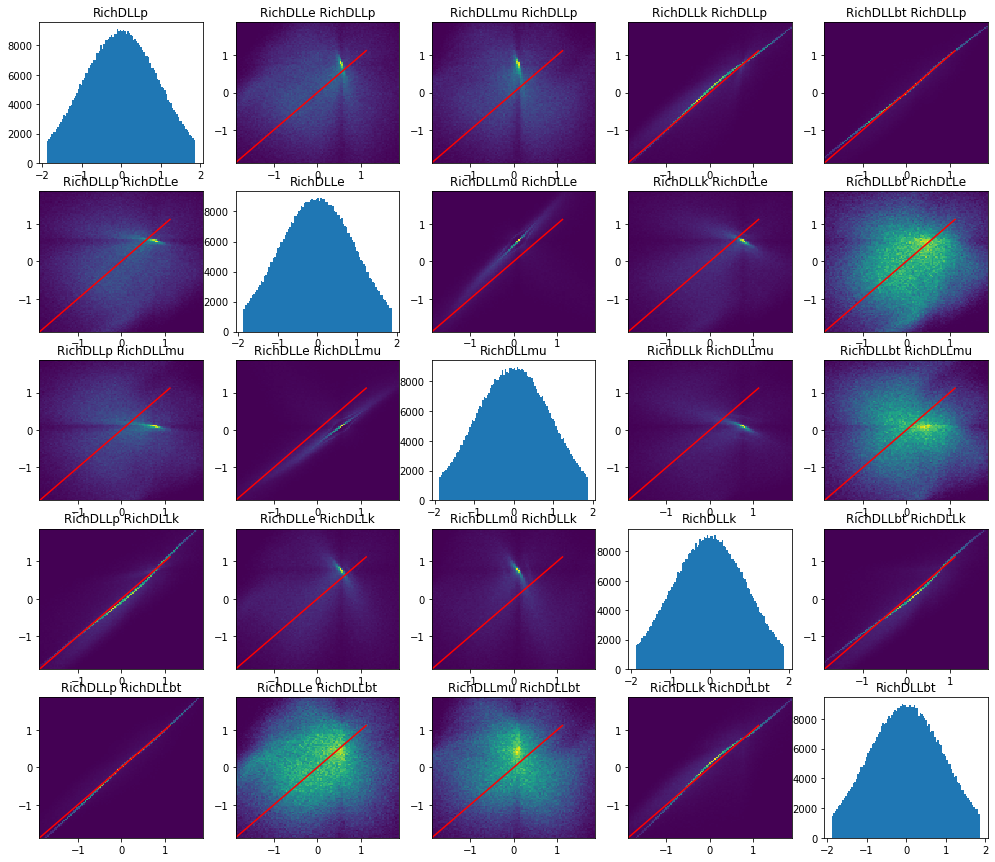

In [32]:
f(d1, dlls)

## Generated data distributions

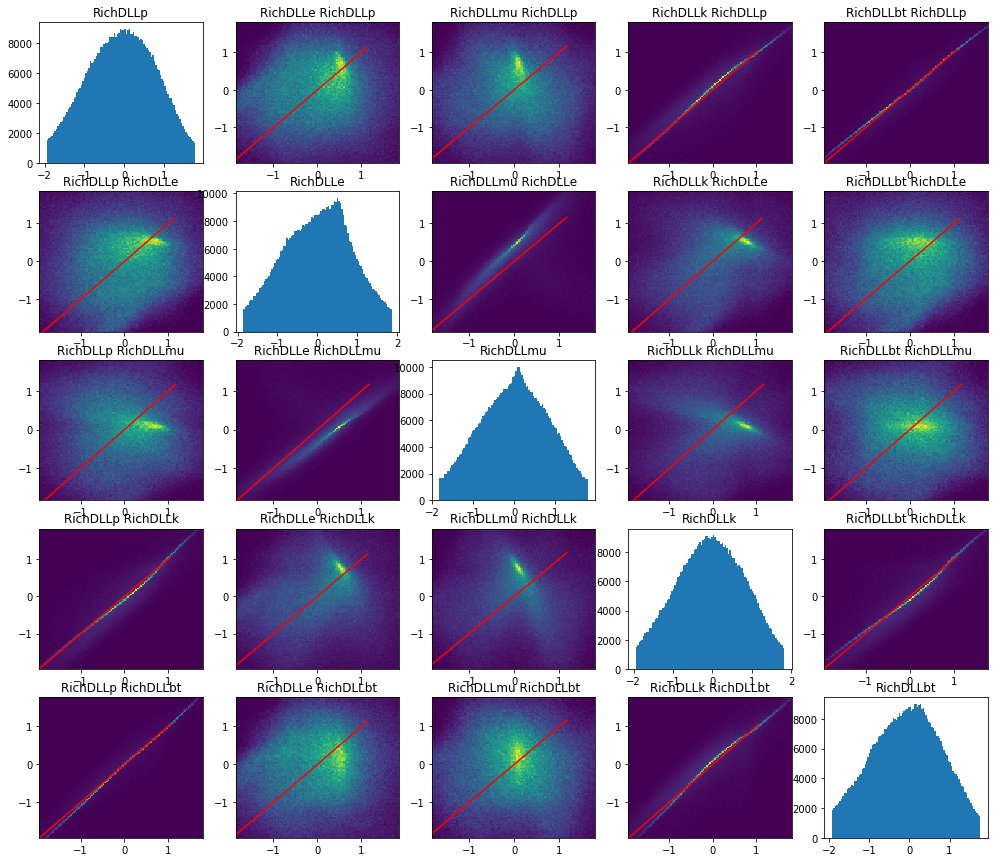

In [33]:
f(d2, dlls)

In [34]:
d1['IsGenerated'] = False
d2['IsGenerated'] = True

In [38]:
classification_ds = shuffle(pd.concat([d1, d2]))
classification_ds.head(5)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,IsGenerated
511050,0.765599,0.930505,0.084604,0.503022,0.815907,False
55854,-1.282329,1.060476,0.753834,-1.218148,-1.312262,True
134499,0.093165,-0.858603,-1.157291,0.001763,0.104283,True
511211,1.011809,3.949626,-0.579302,1.057177,1.002045,True
113102,0.925142,-0.219528,-0.789055,0.163391,0.906202,True


In [39]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((833368, 6), (357158, 6))

In [42]:
params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)
xgb_model = xgb.XGBClassifier(**params)

In [43]:
dlls

['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']

In [44]:
xgb_model.fit(
    X=cls_train[dlls].values,
    y=cls_train['IsGenerated'].values.astype('int32'),
#     sample_weight=cls_train[weight_filed]
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=200, n_jobs=24,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
is_gen_pred = xgb_model.predict(cls_val[dlls].values)
is_gen_true = cls_val['IsGenerated'].values

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls].values)[:, 1]
roc_auc_score(is_gen_true, is_gen_pred_probas)

0.5973256872697967

$d(s)$ - true density  
clf - perfect discriminator (true vs nf)

$$\text{clf}(s) = \frac{d(s)}{d(s) + \text{nf}(s)} $$
$$d(s) = \frac{\text{clf}(s)}{1 - \text{clf}(s)} \text{nf}(s)$$
$$ \log d(s) = \log \text{nf}(s) + \log \text{clf}(s) + \log (1 - \text{clf}(s)) $$

Идея: если clf(s) и (1 - clf(s)) отделены от 1, то d(s) должно нормально посчитаться, а потом сделаем просто importance sampling из него

In [130]:
np.min(is_gen_pred_probas), np.max(is_gen_pred_probas)

(0.15058275, 0.9915746)

In [131]:
class FixedModel:
    def __init__(self, clf, nf):
        self.clf = clf
        self.nf = nf

    def __call__(self, x):
        discr = self.clf.predict_proba(x)[:, 1] # clf(s)
        
        x_tensor = torch.from_numpy(x.astype(np.float32)).to(device)
        _, logp_z, log_det = self.nf(x_tensor)
        logp_x = (logp_z + log_det).detach().cpu().numpy() # nf(s)
        
#         return logp_x + np.log(discr) - np.log1p(-discr) # nf(s) * clf(s) / (1 - clf(s))
        return logp_x + np.log(discr)# - np.log1p(-discr)

In [132]:
f_model = FixedModel(xgb_model, model)

In [133]:
new_data = cls_val[dlls].values[:100]
np.exp(f_model(new_data))

array([8.99663329e-01, 3.65027845e-01, 6.32135104e-03, 2.05937886e+00,
       2.23762941e+00, 8.52168918e-01, 5.68263233e-01, 5.77599332e-02,
       1.83590092e-02, 1.46614686e-01, 8.34684521e-02, 3.95342649e-04,
       2.90032745e+02, 1.85084518e-03, 5.77409446e-01, 1.13565193e+02,
       3.33719820e-01, 6.58663483e+01, 8.65718842e+01, 2.41854053e-04,
       3.80836487e+00, 5.37812104e-03, 5.47555447e-01, 2.27855434e+01,
       6.22917366e+01, 1.41371228e-02, 3.58924133e+02, 1.41549754e+00,
       6.21745110e-01, 1.90700099e-01, 6.07939623e-03, 1.37865710e+00,
       1.99124814e-04, 4.10102904e-01, 2.87403450e+01, 5.93041763e+01,
       1.15447189e+02, 4.21743877e-02, 8.58870804e-01, 3.46750975e-01,
       2.31636837e-01, 1.19827082e-02, 1.62035322e+00, 5.93233826e+02,
       2.10387945e+00, 2.34376743e-01, 6.66220635e-02, 4.42047455e+02,
       1.21376085e+01, 3.32605205e-02, 6.02598935e-02, 1.63924770e+01,
       1.18398714e+00, 4.12374735e-02, 1.71254551e+00, 3.45040083e+00,
      

Вот тут много где очень большая плотность, что кажется не круто, потому что это не похоже на плотность

In [115]:
from scipy.stats import multivariate_normal

In [135]:
multivariate_normal.pdf(np.random.normal(0, 1, (10, 5)), mean=np.zeros(5), cov=np.diag(np.ones(5)))

array([0.0002277 , 0.00044903, 0.00031236, 0.00044765, 0.00496865,
       0.00147409, 0.00134142, 0.00271955, 0.00120947, 0.00249306])

Для примера вот характерные плотности нормального распределения